# PySPDE Tutorial

First, we import the useful classes:

In [130]:
from src.spde import *
from src.linear_solvers import SpectralSolver
from src.noises import WhiteNoise
from src.visualizer import Visualizer
from src.integrators import *
from src.basis import FiniteElementBasis
from src.integrators import Midpoint, ThetaScheme
from src.deriv import DerivativeOperator

from mpl_toolkits import mplot3d
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
matplotlib.rcParams['font.size'] = 24

Set up a simple example problem:

$$
    \partial_\tau u = \ddot{u} - \dot{u}^2/u + \sigma\sqrt{2}\xi(\tau, t),
$$

with $u(\tau, 0) = 1$, $\dot{u}(\tau, 1) = (a - \sigma^2/2)u(\tau, 1)$

First step is to set up simulation parameters

In [131]:
tau_max = 5 # end virtual time for simulation
steps = 1000 # virtual time steps
points = 30 # real time points
linear = 1 # coefficient for the second derivative part
dt = tau_max / steps # virtual time steps

Then, the sampling parameters:

In [132]:
# same as in.ensembles = [16, 4, 4] in xSPDE
blocks = 16
samples = 4
processes = 4

Then the problem parameters:

In [133]:
a = -1
sigma = 0.25

Now we set up the SPDE problem. First, the boundary conditions:

In [134]:
boundaries = [
    Dirichlet(1),
    Robin(lambda u: (a - sigma**2)*u)
]

Then create a time lattice:

In [135]:
lattice = Lattice(
    0, # origin
    1, # endpoint
    points, # number of lattice points
    boundaries, # necessary for whether to include boundary points in lattice
)

# Finite difference derivative operator
d1 = DerivativeOperator(1, lattice, boundaries)

Create an SPDE object:

In [138]:
noise = WhiteNoise(
    1, # variance
    points # dimension of noise vector
)

spde = SPDE(
    linear,
    lambda u: -d1(u)**2/u,
    lambda u: sigma*u*sqrt(2),
    noise
)

# the full problem is specified separately:
problem = StochasticPartialProblem(
    spde,
    boundaries,
    lattice
)

Now we set up the solution method:

In [139]:
# Use the midpoint method with spectral solver for the linear part
#stepper = Midpoint(
#    SpectralSolver(problem),
#    dt
#)

# Use a finite elements method with theta scheme
stepper = ThetaScheme(
    1, # theta = 0: explicit euler, theta = 1/2: Crank-Nicholson, theta = 1: implicit Euler
    lattice,
    FiniteElementBasis(lattice, boundaries),
    dt
)

Now set up a solver for a single trajectory:

In [140]:
# initial condition: u(tau, 0) = 1
initial_condition = np.ones((1, points))

trajectory_solver = TrajectorySolver(
    problem,
    steps,
    tau_max,
    initial_condition,
    stepper
)

Then hand that to the ensemble solver to do a Monte Carlo run:

In [141]:
ensemble_solver = EnsembleSolver(
    trajectory_solver,
    samples,
    blocks=blocks,
    processes=processes,
    observables={
        "value": lambda u: u,
        "square": lambda u: u**2,
    },
    verbose=False, # turn this on to get logging info from all threads
    pbar=True, # turn this on to get a pretty progress bar
    seed=1,
    check=True, # obtain step size errors
)

Perform an MC run:

In [142]:
ensemble_solver.solve()

100%|██████████| 16/16 [00:36<00:00,  2.27s/it]


Extract mean and mean-square data:

In [143]:
mean = ensemble_solver.means["value"][0]
square = ensemble_solver.means["square"][0]

mean_step_error = ensemble_solver.step_errors["value"][0]
mean_sample_error = ensemble_solver.sample_errors["value"][0]

print(f"Max step error: {mean_step_error.max():.5E}")
print(f"Max sample error: {mean_sample_error.max():.5E}")

square_step_error = ensemble_solver.step_errors["square"][0]
square_sample_error = ensemble_solver.sample_errors["square"][0]

Max step error: 1.89506E-02
Max sample error: 2.57754E-02


`Visualizer` is a helper class for producing graphs:

In [144]:
vis_mean = Visualizer(
    mean,
    (0, tau_max),
    lattice,
    sample_error=mean_sample_error,
    step_error=mean_step_error,
)

vis_square = Visualizer(
    square,
    (0, tau_max),
    lattice,
    sample_error=square_sample_error,
    step_error=square_step_error,
)

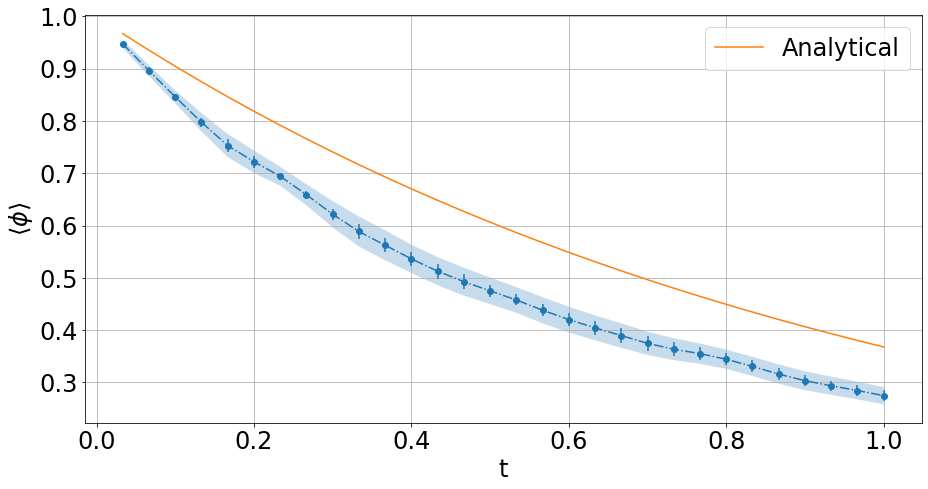

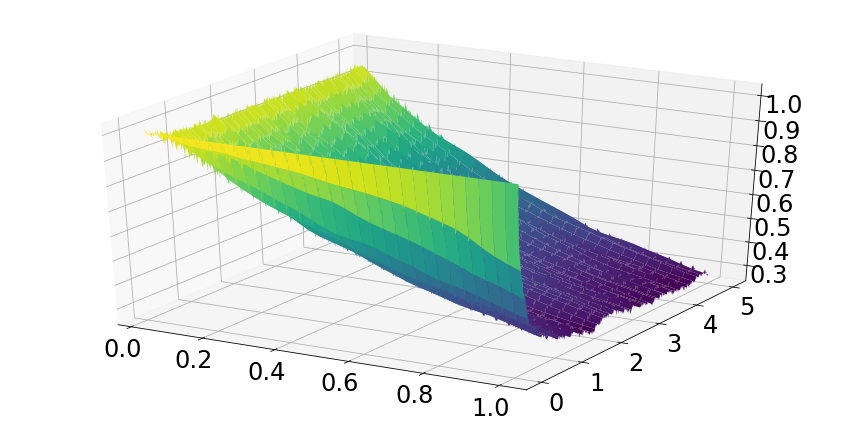

In [148]:
fig_mean_ss, ax_mean_ss = vis_mean.steady_state(marker='o', linestyle='-.')
ax_mean_ss.set_xlabel("t")
ax_mean_ss.set_ylabel(r"$\langle\phi\rangle$")

ax_mean_ss.plot(lattice.points, np.exp(a*lattice.points), label="Analytical")
ax_mean_ss.legend()

fig_mean_surf, ax_mean_surf = vis_mean.surface()

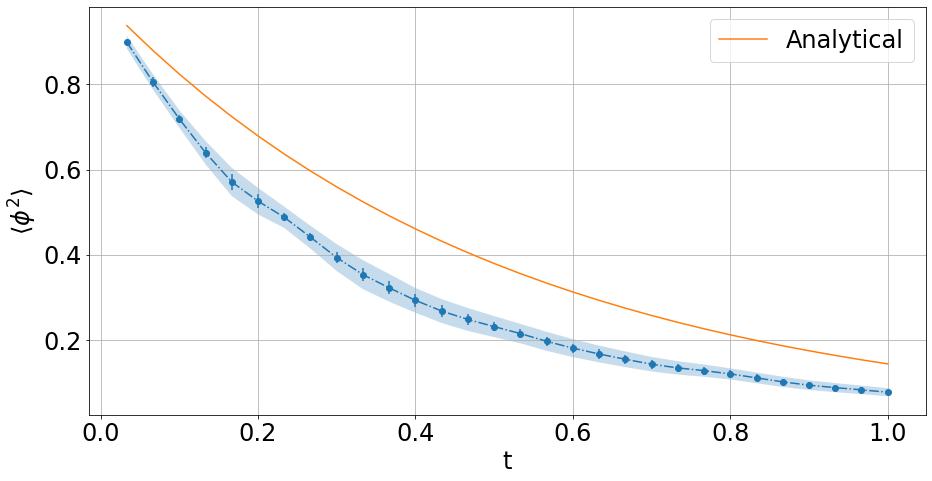

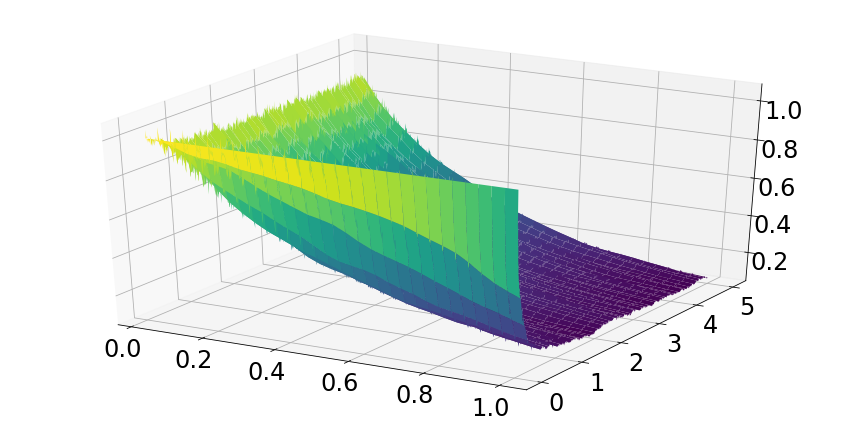

In [149]:
fig_square_ss, ax_square_ss = vis_square.steady_state(marker='o', linestyle='-.')
ax_square_ss.set_xlabel("t")
ax_square_ss.set_ylabel(r"$\langle\phi^2\rangle$")

ax_square_ss.plot(lattice.points, np.exp((2*a + sigma**2)*lattice.points), label="Analytical")
ax_square_ss.legend()

fig_square_surf, ax_square_surf = vis_square.surface()